In [12]:
library('sqldf')
library("xgboost")
library("rpart")
library("dplyr")
library("randomForest")
library("Metrics")
library("caret")
library("repr")

# Reading the data

In [3]:
q2 <- read.csv("C:/Users/gugha/Documents/UIC/1st_Semester/Advanced Statistics/Project/Divvy_Trips_2018_Q2.csv")

# Exploratory Data Analysis 

## Find Top 10 divvy stations with highest rider membership

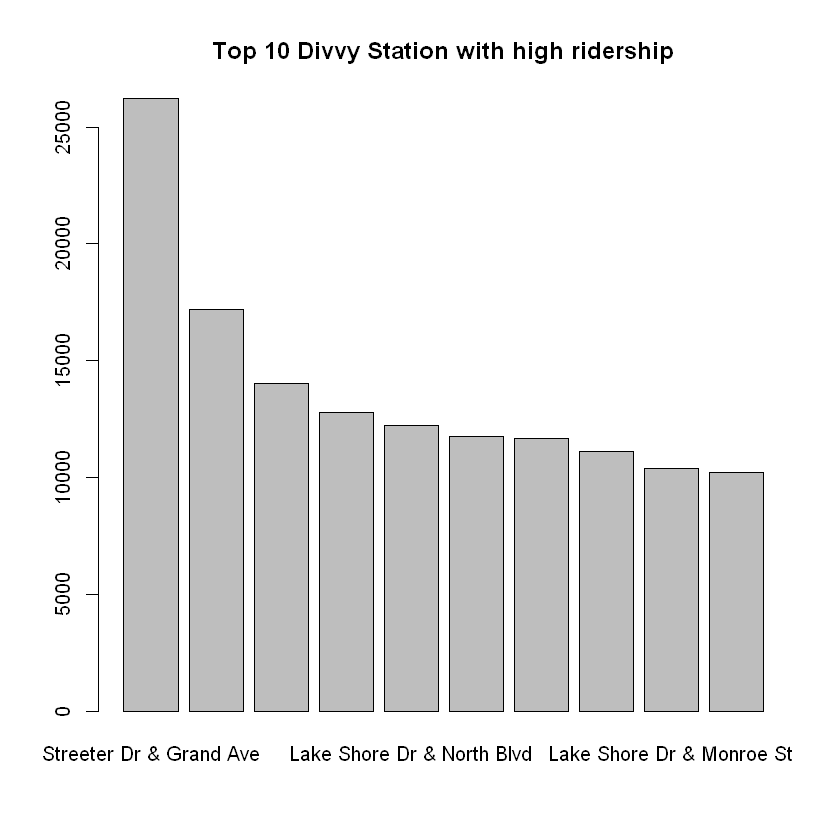

In [4]:
station_agg <- setNames(aggregate(q2$trip_id,by=list(q2$to_station_name),FUN=length),c("Street","Rides"))
station_agg <- station_agg[order(-station_agg$Rides),]
#options(repr.plot.width = 1, repr.plot.height = 0.75,jupyter.plot_mimetypes = 'image/png')
barplot(station_agg$Rides[c(1:10)],names.arg= station_agg$Street[c(1:10)],main="Top 10 Divvy Station with high ridership")

# Feature Engineering

In [7]:
## Usertype column conversion
tmp <- model.matrix(~q2$usertype+0)
colnames(tmp) <- c("customer","subscriber")
q2 <- q2[,!names(q2) %in% c("usertype")]
q2 <- cbind(q2,tmp)

## Gender Column Conversion
tmp <- model.matrix(~q2$gender+0)
colnames(tmp) <- c("gender","Female","Male")
tmp <- tmp[,-1]
q2 <- q2[,!names(q2) %in% c("gender")]
q2 <- cbind(q2,tmp)

###Calculate age 

q2$Age <- 2018 - q2$birthyear 
q2$Age[is.na(q2$Age)] <- mean(q2$Age,na.rm=TRUE)
q2$Age <- as.integer(q2$Age)
q2$Age_Bucket <- ifelse(q2$Age<=18,"18yrs",ifelse(q2$Age>18 & q2$Age<=28,"18_28",ifelse(q2$Age>28 & q2$Age<=38,"28_38",ifelse(q2$Age>28 & q2$Age<=38,"28_38",ifelse(q2$Age>38 & q2$Age<=48,"38_48",ifelse(q2$Age>48 & q2$Age<=58,"48_58","58_More"))))))
tmp <- model.matrix(~q2$Age_Bucket+0)
colnames(tmp) <- c("18yrs","18_28","28_38","38_48","48_58","58More")
q2 <- q2[,!names(q2) %in% c("Age")]
q2 <- cbind(q2,tmp)

## Date and Time in Hour
q2$start_time <- as.POSIXct(q2$start_time)
q2$week_day <- weekdays(q2$start_time)
q2$date <- unlist(lapply(q2$start_time,FUN = function(x)(substr(as.character(x),1,10))))
q2$time_stamp <- unlist(lapply(q2$start_time,FUN = function(x)(substr(as.character(x),12,13))))

q2_agg<- sqldf("select date,from_station_name,count(1) as trips from q2 group by date,from_station_name")

# Calculating Incoming Trips from the source data and merging it with aggregate data 

In [8]:
inc_trips <- q2[,c("date","to_station_name","end_time")]
inc_trips$end_time <- as.POSIXct(inc_trips$end_time)
inc_trips$week_day <- weekdays(inc_trips$end_time)
inc_trips$date <- unlist(lapply(inc_trips$end_time,FUN = function(x)(substr(as.character(x),1,10))))
inc_trips$time_stamp <- unlist(lapply(q2$end_time,FUN = function(x)(substr(as.character(x),12,13))))
inc_trips_cnt <- sqldf("select date,to_station_name,count(1) as In_trips from inc_trips group by date,to_station_name")
colnames(inc_trips_cnt) <- c("date","from_station_name","In_trips")
q2_agg <- merge(q2_agg,inc_trips_cnt,all.x = TRUE,by=c("date","from_station_name"))
q2_agg[is.na(q2_agg)] <- 0

## Reading Divvy stations positional data (lat-long) and calculate the stations within 1 mile using lat-long

In [ ]:
lat_long <- read.csv("C:/Users/gugha/Documents/UIC/1st_Semester/Advanced Statistics/Project/Divvy_Bicycle_Stations_-_All_-_Map.csv")
lat_long <- lat_long[names(lat_long)%in% c("Station.Name","Latitude","Longitude")]
lat_long <- unique(lat_long)
colnames(lat_long) <- c("from_station_name","lat1","long1")
lat_long$id <- 1 
lat_long1<- lat_long
colnames(lat_long1) <- c("to_station_name","lat2","long2","id")
lat_long_final <- merge(lat_long,lat_long1,by=c("id"))
distance1 <- c()
for(i in c(1:nrow(lat_long_final))){
  distance1 <- c(distance1,distVincentyEllipsoid(c(lat_long_final[i,'long1'],lat_long_final[i,'lat1']),c(lat_long_final[i,'long2'],lat_long_final[i,'lat2'])))
}

distance1 <- distance1/1609.344
lat_long_final$mile <- distance1
divvy_mile <- lat_long_final[which(lat_long_final$mile<=0.5 & lat_long_final$mile!=0),]
divvy_mile <- aggregate(divvy_mile$id,by=list(divvy_mile$from_station_name),sum)
colnames(divvy_mile) <- c("from_station_name",'Divvy_1mile')

q2_agg <- merge(q2_agg,divvy_mile,by=c("from_station_name"),all.x=TRUE)

## Merging Neighbourhood data,census data and socio economic indicators obtained from the city of chicago portal and merging it with divvy data

In [ ]:
################################ Neighborhood ######################################
neigh <- read.csv("Divvy_Neighbourhood.csv")
census <- read.csv("Census.csv") 
colnames(census)[1] <- "Neighbourhood"

q2_agg <- merge(q2_agg,neigh,by="from_station_name",all.x=TRUE)
q2_agg <- merge(q2_agg,census,by="Neighbourhood",all.x=TRUE)

census_eco <- read.csv("Census_Data_-_Selected_socioeconomic_indicators_in_Chicago__2008___2012.csv")
census_eco <- census_eco[,-1]
colnames(census_eco) <- c("Neighbourhood","Housing_Crowded","Below_Poverty",'Unemployed_Pop',"No_Diploma","under18orover64","Percapita","Hardship")
census_eco <- census_eco[,-6]
q2_agg <- merge(q2_agg,census_eco,by="Neighbourhood",all.x=TRUE)

write.csv(q2_agg,"model_data.csv")

# Missing Value Treatment using KNN Imputation - Here K=3 is chosen

In [ ]:
final <- knnImputation(q2_agg, k=3)
write.csv(final,"model_data.csv")

# Model Building

## Train - Test Data Split

In [ ]:
Station_Level <- final %>% group_by(from_station_name)%>%summarise(mean(trips),mean(In_trips),mean(Divvy_1mile),mean(cta_rides),mean(cta_station),mean(Tot_Pop,na.rm = T),mean(Male,na.rm = T),mean(Female,na.rm = T),mean(Below_18,na.rm = T),mean(Btw_18_35,na.rm = T),mean(Btw_36_54,na.rm = T),mean(above_54,na.rm = T),mean(Housing_Crowded,na.rm=TRUE),mean(Below_Poverty,na.rm=TRUE),mean(Unemployed_Pop,na.rm=TRUE),mean(No_Diploma,na.rm = TRUE),mean(Percapita,na.rm=TRUE),mean(Hardship,na.rm=TRUE))
colnames(Station_Level) <- c("from_station_name","trips","In_trips","Divvy_1mile","cta_rides","cta_station","Tot_Pop","Male","Female","Below_18","Btw_18_35","Btw_36_54","above_54","Housing_Crowded","Below_Poverty","Unemployed_Pop","No_Diploma","Percapita","Hardship")
Station_Level$Demand_B <- ifelse(Station_Level$trips<=11,"Low",ifelse(final$trips>11&final$trips<=29,"Medium","High"))

set.seed(123)
nr <- nrow(Station_Level)

trnIndex <- sample(1:nr , size = round(0.7*nr) , replace = FALSE)
training_data <- Station_Level[trnIndex,]
View(training_data)

test_data <- Station_Level[-trnIndex,]
plot_rmse <- c()

## Linear Regression

In [ ]:
linearMod <- lm(trips ~ Divvy_1mile + cta_rides + cta_station + Tot_Pop + Male + Female + Below_18
                + Btw_18_35 + Btw_36_54 + above_54+Housing_Crowded+Below_Poverty+Unemployed_Pop
                +No_Diploma+Percapita+Hardship, 
                data = training_data)

#Residual Sum of Squares
pred <- predict(linearMod,training_data)
rmse(pred,training_data$trips)

pred <- predict(linearMod,test_data)
plot_rmse <- c(plot_rmse,rmse(pred,test_data$trips))

## Random Forest

In [ ]:
rf <- randomForest(trips ~ Divvy_1mile + cta_rides + cta_station + Tot_Pop + Male + Female + Below_18
             + Btw_18_35 + Btw_36_54 + above_54+Housing_Crowded+Below_Poverty+Unemployed_Pop
             +No_Diploma+Percapita+Hardship,data=training_data,ntrees=4)

pred <- predict(rf,training_data)
rmse(training_data$trips,pred)
plot(rf)

pred <- predict(rf,test_data)
plot_rmse <- c(plot_rmse,rmse(pred,test_data$trips))

## XGBoost

In [ ]:
train_matrix <- as.matrix(training_data[,c("Divvy_1mile","cta_rides","cta_station","Tot_Pop","Male","Female",
               "Below_18","Btw_18_35","Btw_36_54","above_54",
               "Housing_Crowded","Below_Poverty","Unemployed_Pop","No_Diploma","Percapita","Hardship")])
train_dep_matrix <- as.vector(training_data$trips)

boosted_model <- xgboost(data=train_matrix,label=train_dep_matrix,nfold=1,nrounds=10)

pred <- predict(boosted_model,train_matrix)
rmse(pred,train_dep_matrix)

test_matrix <- as.matrix(test_data[,c("Divvy_1mile","cta_rides","cta_station","Tot_Pop","Male","Female",
                                           "Below_18","Btw_18_35","Btw_36_54","above_54",
                                           "Housing_Crowded","Below_Poverty","Unemployed_Pop","No_Diploma","Percapita","Hardship")])
test_dep_matrix <- as.vector(test_data$trips)
pred <- predict(boosted_model,test_matrix)
plot_rmse <- c(plot_rmse,rmse(pred,test_dep_matrix))

# Model Performances

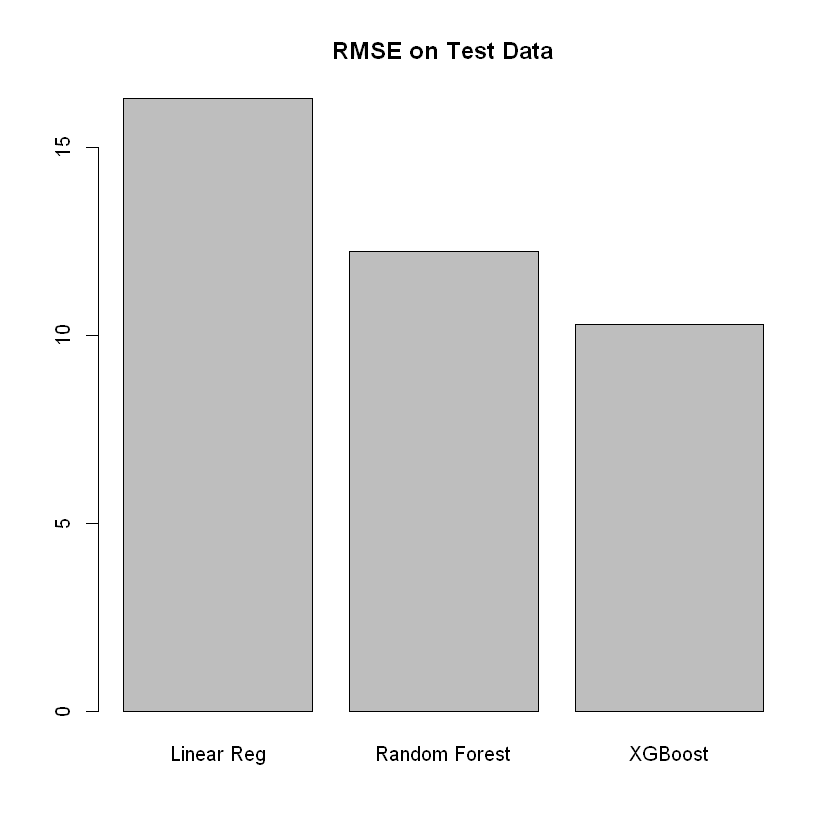

In [18]:
barplot(plot_rmse,names.arg=c("Linear Reg","Random Forest","XGBoost"), main= "RMSE on Test Data")